In [1]:
# Question 4
import pandas as pd 
import numpy as np
import nltk
import re

from textblob import TextBlob

df_merged = pd.read_csv("data/merged_file.csv")
df_cmu = pd.read_csv("dataset/cmu_merged_with_imdb.csv")

# Sentiment Analysis Function
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply Function to DataFrame
df_cmu['sentiment_score'] = df_cmu.PlotSummaries.apply(analyze_sentiment)

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_6592/1430425403.py:9: DtypeWarning: Columns (4,5,7,8,10,12,14,15,16,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv("data/merged_file.csv")


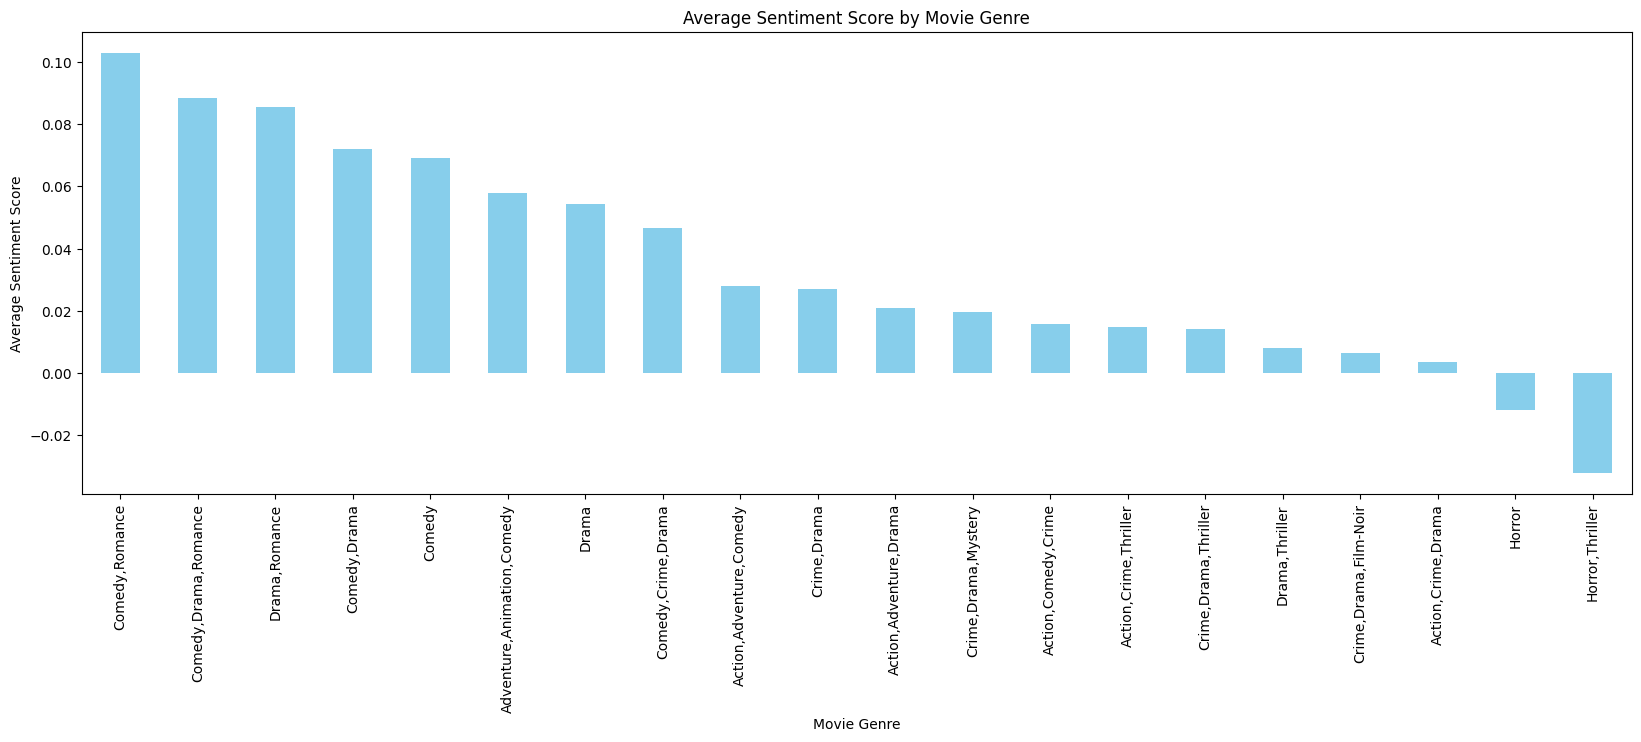

In [2]:
import matplotlib.pyplot as plt
# Preprocessing MovieGenre column (splitting in case of multiple genres and stacking them)
genres_expanded = df_cmu['genres'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
genres_expanded.name = 'SingleGenre'

# Join the expanded genres back to the original dataframe
df_expanded = df_cmu.join(genres_expanded)

# Calculate average sentiment score for each genre
genre_sentiment = df_expanded.groupby('SingleGenre')['sentiment_score'].mean()

# Identify the most frequent genres
top_genres = df_expanded['SingleGenre'].value_counts().head(20).index

# Filter average sentiment by the most frequent genres
top_genre_sentiment = genre_sentiment[top_genres].sort_values(ascending=False)

# Plotting
plt.figure(figsize=(20,6))
top_genre_sentiment.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score by Movie Genre')
plt.xlabel('Movie Genre')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.show()

In [3]:
war_movies = df_cmu[df_cmu['genres'].str.contains('war', case=False, na=False)]

In [ ]:
from transformers import BertModel, BertTokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
import spacy

# Load pre-trained BERT model & tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode
# Load the English tokenizer, tagger, parser, NER, and word vectors

nlp = spacy.load("en_core_web_sm")

# Custom function to filter out verbs and custom stop words
custom_stop_words = {'war', 'soldier', 'military', 'army', 'film', 'army', 'battle', 'combat', 'conflict', 'officer', 'captain', 'killed'}
def filter_verbs_and_custom_stopwords(text):
    doc = nlp(text)
    filtered_text = ' '.join(token.text for token in doc if token.pos_ != 'VERB' and token.text.lower() not in custom_stop_words)
    return filtered_text

# Apply the function to preprocess the texts
war_movies['PlotSummaries'] = [filter_verbs_and_custom_stopwords(text) for text in war_movies.PlotSummaries]
# Function to handle long texts by splitting into chunks
def get_bert_embeddings(text, chunk_size=512):
    # Tokenize input text
    tokens = tokenizer.tokenize(text)
    # Initialize an empty array to store embeddings
    all_embeddings = []
    # Process text in chunks
    for i in range(0, len(tokens), chunk_size-2):  # subtract 2 for [CLS] and [SEP] tokens
        # Prepare tokens for input to BERT
        chunk_tokens = tokens[i:i+chunk_size-2]
        chunk_tokens = ['[CLS]'] + chunk_tokens + ['[SEP]']
        chunk_ids = tokenizer.convert_tokens_to_ids(chunk_tokens)
        chunk_ids_tensor = torch.tensor([chunk_ids]).to('cuda' if torch.cuda.is_available() else 'cpu')

        # Get BERT embeddings for the chunk
        with torch.no_grad():
            chunk_embeddings = model(chunk_ids_tensor).last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        all_embeddings.append(chunk_embeddings)

    # Aggregate the embeddings by averaging
    embeddings = np.mean(all_embeddings, axis=0)
    return embeddings

# Apply the function to your dataset
war_movies['bert_embeddings'] = war_movies['PlotSummaries'].apply(get_bert_embeddings)

# Dimensionality Reduction
pca = PCA(n_components=0.95)  # retain 95% variance
X_reduced = pca.fit_transform(list(war_movies['bert_embeddings']))

# Clustering
kmeans = KMeans(n_clusters=5)
war_movies['topic'] = kmeans.fit_predict(X_reduced)



Cluster 0:
world, 1.799877624841173
com, 1.705351470007026
story, 1.64978589270887
section, 1.411787609087684
synopsis, 1.3624438845802358
korean, 1.3341791720358083
iraq, 1.3267397630885236
british, 1.3176324959150396
chinese, 1.098602497923984
hitler, 1.0807119810293528


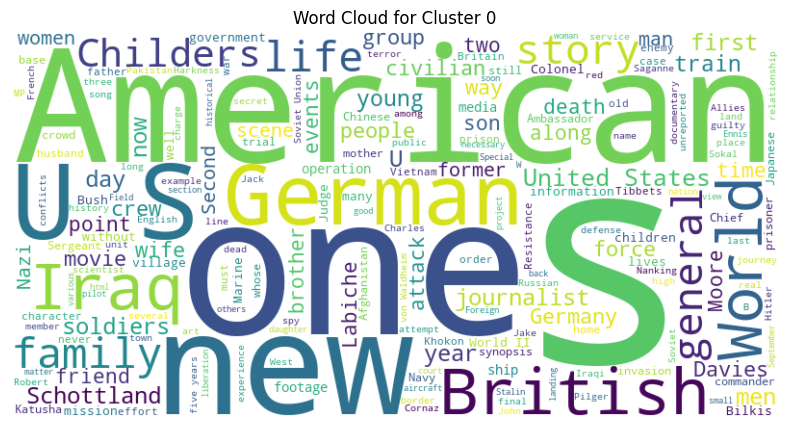

Cluster 1:
young, 2.084531083785262
german, 1.8275610819333474
story, 1.7341364713754643
soldiers, 1.718397927704559
mother, 1.6950976515928904
life, 1.6666717814607106
world, 1.6056793812220491
priest, 1.5636661558558385
family, 1.521533400093601
resistance, 1.4672978453097185


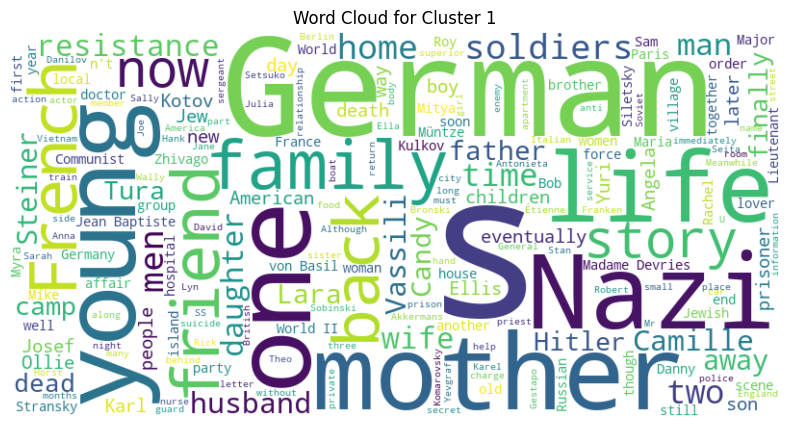

Cluster 2:
american, 2.9503966288370966
world, 2.704759123054985
german, 2.1224813760936625
ii, 1.6421471527069875
family, 1.5097305639771514
korean, 1.4787421968865462
home, 1.4001171411684028
group, 1.3429007383594476
allied, 1.3149913303902507
young, 1.312302877533135


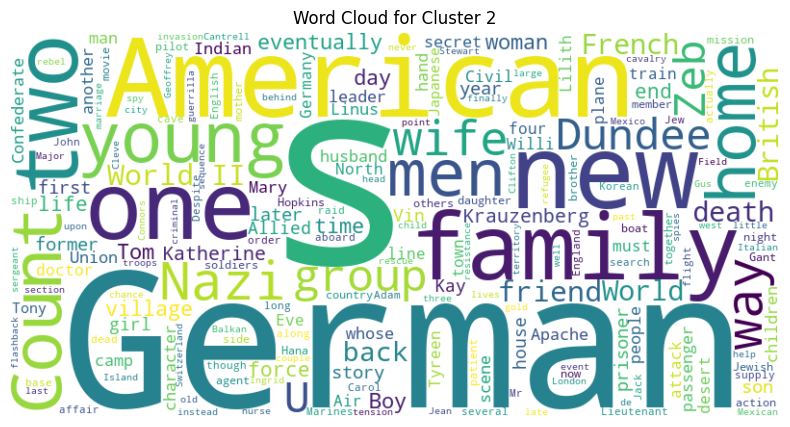

Cluster 3:
soldiers, 3.244413591777865
japanese, 3.1397629929498554
men, 2.189702100590756
father, 2.1082782408520933
later, 2.0985352653462916
village, 2.08306403651891
camp, 2.076805337446899
american, 1.9893244772567331
german, 1.8651624645414295
town, 1.8379487666127021


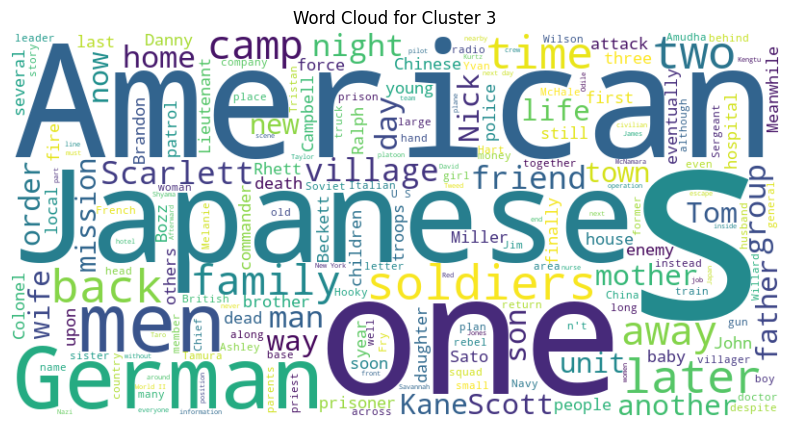

Cluster 4:
japanese, 5.01790357463298
men, 4.01595350421311
german, 3.8845839900691344
sergeant, 3.0220864144172754
commander, 2.9270836169771606
british, 2.9008619309374586
soldiers, 2.879673282947532
platoon, 2.807941724729003
crew, 2.693848453702
general, 2.6539385551340904


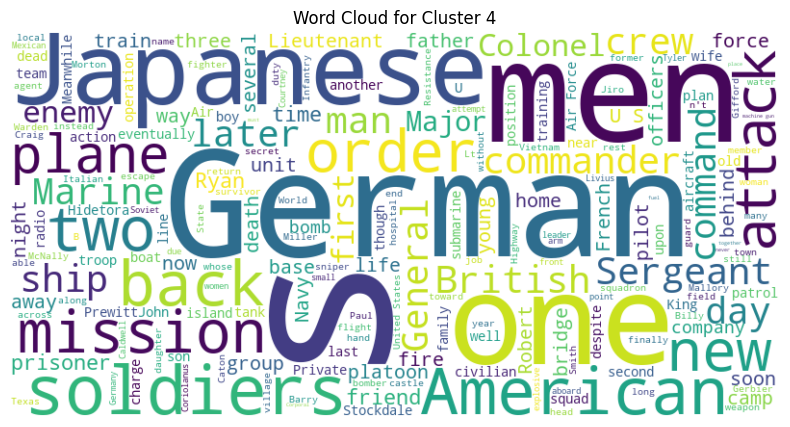

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from nltk.corpus import stopwords
import spacy

# Custom function to filter out verbs and custom stop words
custom_stop_words = {'war', 'soldier', 'military', 'army', 'film', 'army', 'battle', 'combat', 'conflict', 'officer', 'captain', 'killed', 'will', 'love'}
def filter_verbs_and_custom_stopwords(text):
    doc = nlp(text)
    filtered_text = ' '.join(token.text for token in doc if token.pos_ != 'VERB' and token.text.lower() not in custom_stop_words)
    return filtered_text

# Apply the function to preprocess the texts
processed_texts = [filter_verbs_and_custom_stopwords(text) for text in war_movies.PlotSummaries]


# Now you can proceed with TF-IDF vectorization and clustering as before
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(processed_texts)


# Assuming war_movies['bert_embeddings'] is a Series where each row contains an array of embeddings
embeddings_list = war_movies['bert_embeddings'].tolist()  # Convert to list of arrays
embeddings_array = np.vstack(embeddings_list)  # Stack to create a 2D array

# Now you can fit KMeans with this array
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embeddings_array)
clusters = kmeans.labels_


# Analyze the clusters
for cluster in range(n_clusters):
    # Get the texts and tf-idf features for documents in this cluster
    cluster_texts = [processed_texts[i] for i in range(len(processed_texts)) if clusters[i] == cluster]
    cluster_features = tfidf[clusters == cluster]

    # Get top words for this cluster based on tf-idf scores
    words_freq = cluster_features.sum(axis=0)
    words = [(word, words_freq[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
    top_words = sorted(words, key=lambda x: x[1], reverse=True)[:10]
    top_words = [word for word in top_words if word[0] not in custom_stop_words]

    # Print the top words for the cluster
    print(f"Cluster {cluster}:")
    for word, score in top_words:
        print(f"{word}, {score}")

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_texts))

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

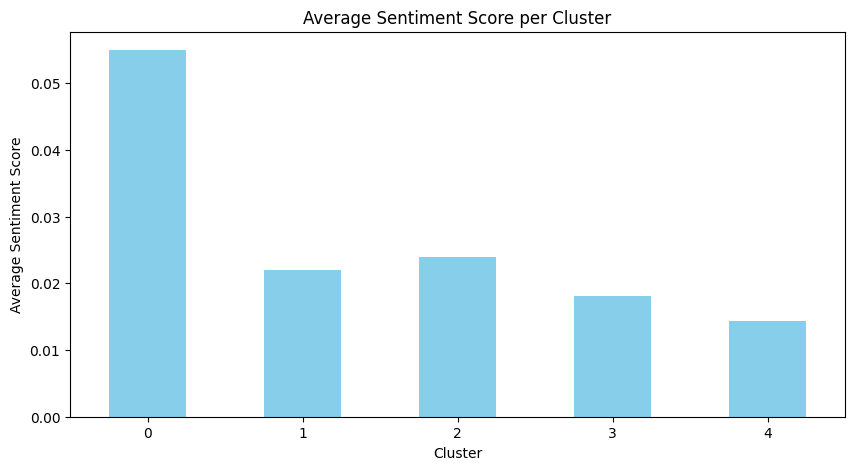

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame that includes 'sentiment_score' and 'cluster_label' columns
# Calculate the average sentiment for each cluster
average_sentiment_per_cluster = war_movies.groupby('topic')['sentiment_score'].mean()

# Plotting the results
plt.figure(figsize=(10, 5))
average_sentiment_per_cluster.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()